# Forecast Taxa Selic

Estudo focado em entender a taxa Selic no Brasil e prevê-la nos próximos períodos. Além disso, será útil entender também qual a influência desta taxa nos investimentos de renda fixa.

### O que é a taxa Selic?

[Fonte](https://www.cnnbrasil.com.br/business/taxa-selic-o-que-e-como-e-definida-e-quais-fatores-influenciam-seu-sobe-e-desce/)

A taxa Selic é usada pelo Banco Central para influenciar as outras taxas de juros do país, praticadas por bancos e demais instituições do sistema financeiro para definir, por exemplo, quanto o consumidor pagará por um empréstimo ou, ainda, o valor que um investidor vai receber por algum título que adquiriu.

A Selic Meta – que será chamada apenas de Selic para facilitar a explicação – é definida nas reuniões do Copom (Comitê de Política Monetária), que acontecem a cada 45 dias. O Copom é formado por diretores e pelo presidente do Banco Central do Brasil, que definem a taxa que passa a vigorar durante um mês e meio após a reunião, até que uma nova aconteça.

Alguns fatores que impactam a decisão de aumento ou redução da Selic:

* Perfil dos títulos públicos federais negociados
* Pressões inflacionárias
* Nível de emprego
* Renda da população

### Como a Selic influencia a inflação?

As pressões inflacionárias também impactam a taxa de juros. A Selic é utilizada pelo Banco Central como estratégia para conter o aumento de preços. Se as autoridades do Copom entendem que existe uma expectativa de aumento da inflação para os próximos meses, a tendência é que o Banco Central opte por aumentar a taxa básica de juros para frear o consumo.

Com relação ao nível de emprego e renda, essas variáveis também acabam por impactar a inflação. Com a população mais empregada e com mais dinheiro no bolso, ela tende a gastar mais. Com isso, pode haver pressão sobre os preços. E, como o Banco Central entende que a taxa Selic é um remédio para domar esses preços, novamente, ela será usada para esfriar o consumo.

Porém, o uso rotineiro dessa estratégia de usar os juros para controlar os preços é contestada por alguns especialistas, porque não é sempre que o aumento dos preços está relacionado ao aumento do crédito e do consumo.

### Como a Selic impacta os investimentos em renda fixa?

Títulos públicos, CDBs, letras de crédito (LCIs, LCAs), debêntures e outros tipos de títulos privados pós-fixados. Essas modalidades de investimentos, classificadas como renda fixa, são sempre favorecidas pela Selic alta.

Há ainda investimentos atrelados à inflação que possuem uma relação indireta com a Selic. Como a taxa básica de juros é usada pelo Banco Central como estratégia para domar a inflação, conforme a inflação aumenta e a Selic também avança para tentar contê-la, a rentabilidade desses investimentos aumenta.

## 0.0. Imports

In [223]:
import pandas as pd
import numpy as np

import requests
from bs4 import BeautifulSoup
import os

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
import time

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

import pmdarima as pm
from pmdarima import model_selection
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

## 0.1. Funções Auxiliares

In [178]:
def display_metrics(test_periods, model, mae, mse, mape):
    metrics = pd.DataFrame()
    metrics['Test Periods'] = test_periods
    metrics['Model'] = model
    metrics['MAE'] = mae
    metrics['MSE'] = mse
    metrics['MAPE'] = mape
    print(f"Mean MAE: {metrics['MAE'].mean()}")
    print(f"Mean MSE: {metrics['MSE'].mean()}")
    print(f"Mean MAPE: {metrics['MAPE'].mean()}")

    return metrics

## 1.0. Coletando Dados

In [92]:
# colocando opcao para nao abrir o browser
options = webdriver.ChromeOptions()
options.add_argument('headless')

# instanciando driver
driver = webdriver.Chrome(service = Service(ChromeDriverManager().install()), options = options)
# driver = webdriver.Chrome(service = Service(ChromeDriverManager().install()))

### 1.1. Selic

In [93]:
# obtendo html da tabela
url_selic = 'https://www.bcb.gov.br/controleinflacao/historicotaxasjuros'
driver.get(url_selic)
time.sleep(1)
html = driver.page_source
table = driver.find_element(By.ID, "historicotaxasjuros")
table_html = table.get_attribute('outerHTML')

In [94]:
# transformando html em dataframe
df_raw = pd.read_html(table_html)[0]
df_raw.columns = ['reuniao', 'data', 'vies', 'periodo_vigencia', 'meta_selic_aa', 'tban_am', 'taxa_selic', 'taxa_selic_aa']
df_raw.head()

,reuniao,data,vies,periodo_vigencia,meta_selic_aa,tban_am,taxa_selic,taxa_selic_aa
0,248º,03/08/2022,NaN,04/08/2022 -,1375,NaN,NaN,NaN
1,247º,15/06/2022,NaN,17/06/2022 - 03/08/2022,1325,NaN,168.0,1315.0
2,246º,04/05/2022,NaN,05/05/2022 - 16/06/2022,1275,NaN,143.0,1265.0
3,245º,16/03/2022,NaN,17/03/2022 - 04/05/2022,1175,NaN,145.0,1165.0
4,244º,02/02/2022,NaN,03/02/2022 - 16/03/2022,1075,NaN,113.0,1065.0


### 1.2. Desemprego

In [95]:
# obtendo html da tabela
url_desemprego = 'https://br.investing.com/economic-calendar/brazilian-unemployment-rate-411'
driver.get(url_desemprego)
time.sleep(1)

# clicar no "Exibir Mais" até o fim
exibir_mais = driver.find_element(By.LINK_TEXT, "Exibir mais")
i = 0
retry = 0
while exibir_mais and retry < 5:
    try:
        exibir_mais.click()
        print(i, end = ', ')
        time.sleep(2.5)
        exibir_mais = driver.find_element(By.LINK_TEXT, "Exibir mais")
        retry = 0
    except:
        time.sleep(2)
        retry += 1
        print(f"Retry {retry}", end = ', ')
        continue
    i += 1
    # se tabela encontrar valor final de 2001, finalizar loop
    table = driver.find_element(By.ID, "eventHistoryTable411")
    table_html = table.get_attribute('outerHTML')
    df_desemprego = pd.read_html(table_html)[0].iloc[:, :-1]
    df_desemprego.columns = ['lancamento', 'hora', 'atual', 'projecao', 'anterior']
    if df_desemprego.iloc[-1, 0][:10].endswith('2001'):
        break

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 

In [96]:
print(df_desemprego.shape)
df_desemprego.tail()

(246, 5)


,lancamento,hora,atual,projecao,anterior
241,01.04.2002 (Mar),06:00,"12,90%",NaN,"12,50%"
242,01.03.2002 (Fev),06:00,"12,50%",NaN,"11,10%"
243,01.02.2002 (Jan),06:00,"11,10%",NaN,"10,60%"
244,01.01.2002 (Dez),06:00,"10,60%",NaN,"11,50%"
245,01.12.2001 (Nov),06:00,"11,50%",NaN,"11,70%"


### 1.3. IPCA (Inflação)


In [97]:
# obtendo html da tabela
url_ipca = 'https://www3.bcb.gov.br/sgspub/consultarvalores/consultarValoresSeries.do?method=consultarSeries&series=13522'
driver.get(url_ipca)
time.sleep(1)
html = driver.page_source
table = driver.find_element(By.ID, "valoresSeries")
table_html = table.get_attribute('outerHTML')

In [98]:
# transformando html em dataframe
df_ipca = pd.read_html(table_html)[0]
df_ipca.columns = ['data', 'ipca_acumulado_12_meses']
df_ipca = df_ipca.iloc[3:-2, :].reset_index(drop = True)
df_ipca

,data,ipca_acumulado_12_meses
0,dez/1980,9925
1,jan/1981,9967
2,fev/1981,10307
3,mar/1981,10103
4,abr/1981,10327
...,...,...
495,mar/2022,1130
496,abr/2022,1213
497,mai/2022,1173
498,jun/2022,1189


In [99]:
# obtendo projecao
url_ipca = 'https://www3.bcb.gov.br/sgspub/consultarvalores/consultarValoresSeries.do?method=consultarSeries&series=433'
driver.get(url_ipca)
time.sleep(1)
html = driver.page_source
table = driver.find_element(By.ID, "valoresSeries")
table_html = table.get_attribute('outerHTML')

url_proj = 'https://www.anbima.com.br/pt_br/informar/estatisticas/precos-e-indices/projecao-de-inflacao-gp-m.htm'
driver.get(url_proj)
time.sleep(1)
html_proj = driver.page_source
table_proj = driver.find_element(By.CLASS_NAME, "tab-content")
table_proj_html = table_proj.get_attribute('outerHTML')

In [100]:
# transformando html em dataframe
df_ipca_mensal = pd.read_html(table_html)[0]
df_ipca_mensal.columns = ['data', 'ipca_mensal']
df_ipca_mensal = df_ipca_mensal.iloc[3:-2, :].copy()
df_ipca_mensal.head()

,data,ipca_mensal
3,jan/1980,662
4,fev/1980,462
5,mar/1980,604
6,abr/1980,529
7,mai/1980,570


In [101]:
# transformando html em dataframe
df_proj = pd.read_html(table_proj_html)[3]
df_proj_next = pd.read_html(table_proj_html)[4]

df_proj = df_proj.iloc[1:, :].copy()
df_proj_next = df_proj_next.iloc[1:, :].copy()

df_proj.columns = ['mes_de_coleta', 'data', 'projecao', 'data_de_validade']
df_proj_next.columns = ['mes_de_coleta', 'data', 'projecao']

print(df_proj)
print(df_proj_next)

    mes_de_coleta      data projecao data_de_validade
1  Agosto de 2022  09/08/22     -023         16/08/22
2  Agosto de 2022  24/08/22     -033         25/08/22
    mes_de_coleta      data projecao
1  Agosto de 2022  09/08/22      046
2  Agosto de 2022  24/08/22      029


## 2.0. Limpando e Manipulando Dados

### 2.1. Arrumando numéricos e data

**taxa_selic**, **meta_selic**, **taxa_selic_aa**, **ipca_acumulado_12_meses**, **ipca_mensal** e **projecao**: como o separador de decimal estava como vírgula, dividir valores por 100.

In [102]:
df2 = df_raw.copy()
df2_desemprego = df_desemprego.copy()
df2_ipca = df_ipca.copy()
df2_ipca_mensal = df_ipca_mensal.copy()
df2_proj = df_proj.copy()
df2_proj_next = df_proj_next.copy()

In [103]:
# Selic - dividindo valores por 100
df2['meta_selic_aa'] = df2['meta_selic_aa'] / 100
df2['taxa_selic'] = df2['taxa_selic'] / 100
df2['taxa_selic_aa'] = df2['taxa_selic_aa'] / 100

# IPCA - substituindo pontos e virgulas por strings vazias e dividindo por 100
df2_ipca['ipca_acumulado_12_meses'] = df2_ipca['ipca_acumulado_12_meses'].str.replace('.', '', regex=True).str.replace(',', '', regex=True).astype(float) / 100
df2_ipca_mensal['ipca_mensal'] = df2_ipca_mensal['ipca_mensal'].str.replace('.', '', regex=True).str.replace(',', '', regex=True).astype(float) / 100

# IPCA projecao - substituindo pontos e virgulas por strings vazias, dividindo por 100 e verificando se e negativo ou nao
df2_proj['negative'] = df2_proj['projecao'].apply(lambda x: True if '-' in x else False)
df2_proj['projecao'] = df2_proj['projecao'].str.replace('.', '', regex=True).str.replace(',', '', regex=True).str.replace('-', '0', regex=True).astype(float) / 100
df2_proj.loc[df2_proj['negative'], 'projecao'] = np.negative(df2_proj.loc[df2_proj['negative'], 'projecao'])

df2_proj_next['negative'] = df2_proj_next['projecao'].apply(lambda x: True if '-' in x else False)
df2_proj_next['projecao'] = df2_proj_next['projecao'].str.replace('.', '', regex=True).str.replace(',', '', regex=True).str.replace('-', '0', regex=True).astype(float) / 100
df2_proj_next.loc[df2_proj_next['negative'], 'projecao'] = np.negative(df2_proj_next.loc[df2_proj_next['negative'], 'projecao'])

df2_proj_next.head()

,mes_de_coleta,data,projecao,negative
1,Agosto de 2022,09/08/22,0.46,False
2,Agosto de 2022,24/08/22,0.29,False


**atual**, **projecao** e **anterior**: retirar % e trocar vírgula por ponto.

In [104]:
df2_desemprego['atual'] = df2_desemprego['atual'].str[:-2].replace(',', '.', regex = True).astype(float)
df2_desemprego['projecao'] = df2_desemprego['projecao'].str[:-2].replace(',', '.', regex = True).astype(float)
df2_desemprego['anterior'] = df2_desemprego['anterior'].str[:-2].replace(',', '.', regex = True).astype(float)
df2_desemprego.head()

,lancamento,hora,atual,projecao,anterior
0,31.08.2022,09:00,9.0,NaN,9.0
1,29.07.2022,09:00,9.0,9.0,9.0
2,30.06.2022,09:00,9.0,NaN,10.0
3,31.05.2022,09:00,10.0,NaN,11.0
4,29.04.2022,09:00,11.0,11.0,11.0


### 2.2. Transformando em granularidade diária

In [105]:
# Selic
df2['data'] = pd.to_datetime(df2['data'], format = "%d/%m/%Y")
df2['periodo_vigencia_min'] = pd.to_datetime(df2['periodo_vigencia'].apply(lambda x: x[:10]), format = "%d/%m/%Y")
df2['periodo_vigencia_max'] = pd.to_datetime(df2['periodo_vigencia'].apply(lambda x: x[-10:] if len(x) == 23 else np.nan), format = "%d/%m/%Y")

# Desemprego
df2_desemprego['lancamento'] = pd.to_datetime(df2_desemprego['lancamento'].str[:10], format = "%d.%m.%Y")
df2_desemprego['lancamento_lag'] = df2_desemprego['lancamento'].shift(1)

# IPCA Acumulado
df2_ipca[['mes', 'ano']] = df2_ipca['data'].str.split('/', expand = True)
df2_ipca['mes'] = df2_ipca['mes'].map({'jan': 1, 'fev': 2, 'mar': 3, 'abr': 4, 'mai': 5, 'jun': 6, 'jul': 7, 'ago': 8, 'set': 9, 'out': 10, 'nov': 11, 'dez': 12})
df2_ipca['ano'] = df2_ipca['ano'].astype(int)

# IPCA Mensal
df2_ipca_mensal[['mes', 'ano']] = df2_ipca_mensal['data'].str.split('/', expand = True)
df2_ipca_mensal['mes'] = df2_ipca_mensal['mes'].map({'jan': 1, 'fev': 2, 'mar': 3, 'abr': 4, 'mai': 5, 'jun': 6, 'jul': 7, 'ago': 8, 'set': 9, 'out': 10, 'nov': 11, 'dez': 12})
df2_ipca_mensal['ano'] = df2_ipca_mensal['ano'].astype(int)

# IPCA Projecoes
df2_proj['data'] = pd.to_datetime(df2_proj['data'], format = "%d/%m/%y")
df2_proj['ano'] = df2_proj['data'].dt.year
df2_proj['mes'] = df2_proj['data'].dt.month

df2_proj_next['data'] = pd.to_datetime(df2_proj_next['data'], format = "%d/%m/%y")
df2_proj_next['ano'] = df2_proj_next['data'].dt.year
df2_proj_next['mes'] = df2_proj_next['data'].dt.month

df2.head()

,reuniao,data,vies,periodo_vigencia,meta_selic_aa,tban_am,taxa_selic,taxa_selic_aa,periodo_vigencia_min,periodo_vigencia_max
0,248º,2022-08-03,NaN,04/08/2022 -,13.75,NaN,NaN,NaN,2022-08-04,NaT
1,247º,2022-06-15,NaN,17/06/2022 - 03/08/2022,13.25,NaN,1.68,13.15,2022-06-17,2022-08-03
2,246º,2022-05-04,NaN,05/05/2022 - 16/06/2022,12.75,NaN,1.43,12.65,2022-05-05,2022-06-16
3,245º,2022-03-16,NaN,17/03/2022 - 04/05/2022,11.75,NaN,1.45,11.65,2022-03-17,2022-05-04
4,244º,2022-02-02,NaN,03/02/2022 - 16/03/2022,10.75,NaN,1.13,10.65,2022-02-03,2022-03-16


In [106]:
df2_daily = pd.DataFrame(columns = ['data', 'selic'])
df2_daily_desemprego = pd.DataFrame(columns = ['data', 'desemprego'])

for index, row in df2.sort_values(by = 'data').iterrows():
    # definindo dia mínimo e máximo (se máximo for nulo, colocar data de hoje)
    min_date = row['periodo_vigencia_min']
    max_date = row['periodo_vigencia_max'] if not pd.isnull(row['periodo_vigencia_max']) else pd.Timestamp.today()
    
    df_append = pd.DataFrame({'data': pd.date_range(min_date, max_date, freq='D')})
    df_append['selic'] = row['meta_selic_aa']
    df2_daily = pd.concat([df2_daily, df_append])

for index, row in df2_desemprego.sort_values(by = 'lancamento').iterrows():
    # definindo dia mínimo e máximo (se máximo for nulo, colocar data de hoje)
    min_date = row['lancamento']
    max_date = row['lancamento_lag'] if not pd.isnull(row['lancamento_lag']) else pd.Timestamp.today()
    
    df_append = pd.DataFrame({'data': pd.date_range(min_date, max_date, freq='D')})
    df_append['desemprego'] = row['atual']
    df2_daily_desemprego = pd.concat([df2_daily_desemprego, df_append])

df2_daily['ano'] = df2_daily['data'].dt.year
df2_daily['mes'] = df2_daily['data'].dt.month

df2_daily = df2_daily.merge(df2_daily_desemprego, on = ['data'])

df2_daily.head()

,data,selic,ano,mes,desemprego
0,2001-12-01,19.0,2001,12,11.5
1,2001-12-02,19.0,2001,12,11.5
2,2001-12-03,19.0,2001,12,11.5
3,2001-12-04,19.0,2001,12,11.5
4,2001-12-05,19.0,2001,12,11.5


### 2.3. Limpeza de dados

Visto que as taxas de juros só começaram a ser fixadas na expressão anual a partir de 02/01/1998, dados antes desta data serão ignorados.

In [107]:
df2_daily.shape

(7830, 5)

In [108]:
df2_daily = df2_daily.query('data >= "1998-01-02"')

In [109]:
df2_daily.shape

(7830, 5)

### 2.4. Transformando em granularidade mensal

Para obter a taxa Selic mensal, transforma-se a base em granularidade diária e então calcula-se a média ponderada no mês da taxa.

In [110]:
# calculando média ponderada
aux = df2_daily.groupby(['ano', 'mes', 'selic']).count().reset_index()
wm = lambda x: np.average(x, weights = aux.loc[x.index, "data"])
df2_monthly = aux.groupby(['ano', 'mes']).agg({'selic': wm}).reset_index()

aux_desemprego = df2_daily.groupby(['ano', 'mes', 'desemprego']).count().reset_index()
wm_desemprego = lambda x: np.average(x, weights = aux_desemprego.loc[x.index, "data"])
df2_monthly_desemprego = aux_desemprego.groupby(['ano', 'mes']).agg({'desemprego': wm_desemprego}).reset_index()

df2_monthly = df2_monthly.merge(df2_monthly_desemprego, on = ['ano', 'mes'])
df2_monthly = df2_monthly.merge(df2_ipca, on = ['mes', 'ano'])
df2_monthly['data'] = pd.to_datetime(df2_monthly['ano'].astype(str) + '-' + df2_monthly['mes'].astype(str), format = "%Y-%m")
df2_monthly

,ano,mes,selic,desemprego,data,ipca_acumulado_12_meses
0,2001,12,19.000000,11.500000,2001-12-01,7.67
1,2002,1,19.000000,10.628125,2002-01-01,7.62
2,2002,2,18.931034,11.082759,2002-02-01,7.51
3,2002,3,18.664062,12.456250,2002-03-01,7.75
4,2002,4,18.500000,12.887097,2002-04-01,7.98
...,...,...,...,...,...,...
243,2022,3,11.265152,11.000000,2022-03-01,11.30
244,2022,4,11.750000,11.000000,2022-04-01,12.13
245,2022,5,12.625000,10.968750,2022-05-01,11.73
246,2022,6,12.991935,9.967742,2022-06-01,11.89


### 2.5. Projeções acumuladas para IPCA

In [111]:
df2_teste = df2_ipca_mensal[-12:]
ipca_proj_acumulado = ((1+df2_teste['ipca_mensal'] * 0.01).rolling(window=12).apply(np.prod, raw=True) - 1).values[-1]
ipca_proj_acumulado

0.1006923519828753

## 3.0. Feature Engineering

In [112]:
df3 = df2_monthly.copy()

### 3.1. Anos de eleição

Eleições acontecem a cada 4 anos, sendo a primeira em 1998 na nossa base de dados.

In [113]:
# eleicao
years_eleicao = np.arange(1994, pd.Timestamp.today().year + 1, 4)
df3.loc[df3['ano'].isin(years_eleicao), 'eleicao'] = 1
df3['eleicao'] = df3['eleicao'].fillna(0)

## 4.0. EDA

In [114]:
df4 = df3.copy()

### 4.1. Eleição, Desemprego e Inflação

Sabe-se que anos de eleição costumam agitar o país e serem anos mais instáveis. Não é possível identificar um padrão claro do comportamento da taxa Selic nesses períodos, fora o fato de que, pós eleição de um novo presidente, a taxa costuma subir (1998, 2002, 2010, 2014), com exceção de 2006 (reeleição de Lula) e 2018 (eleição de Bolsonaro).

Em relação ao desemprego, verifica-se que há uma tendência diretamente proporcional a Selic até 2017, aproximadamente, onde a taxa de desemprego se manteve praticamente constante em altas taxas enquanto a taxa Selic caia. Também, uma possível influência da taxa de desemprego na inflação é o fato de que uma população bem empregada e com dinheiro no bolso tende a gastar mais, podendo haver uma pressão sobre os preços. Assim, a Selic pode ser utilizada para conter tais preços e esfriar o consumo.

Por fim, em relação a inflação, verifica-se que a Selic acompanha a variação do IPCA, comcomitantemente, ou um pouco tardiamente, o que faz sentido, visto que uma das motivações do valor da taxa Selic é controlar pressões inflacionárias de forma reativa, sendo que uma expectativa de alta na inflação faz com que a taxa Selic aumente, para tentar controlar o consumo. Por outro lado, uma baixa inflação permite que o consumo seja estimulado, e dessa forma, decidem por diminuir a taxa básica de juros Selic.

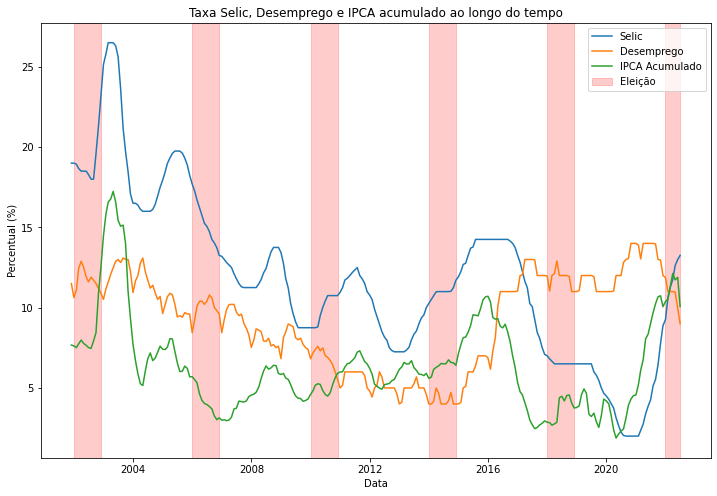

In [115]:
fig, ax = plt.subplots(figsize = (12, 8))
sns.lineplot(data = df4, x = 'data', y = 'selic', ax = ax, label = 'Selic');
sns.lineplot(data = df4, x = 'data', y = 'desemprego', ax = ax, label = 'Desemprego');
sns.lineplot(data = df4, x = 'data', y = 'ipca_acumulado_12_meses', ax = ax, label = 'IPCA Acumulado');
max_min_date_year = df4.query("eleicao == 1").groupby('ano')['data'].agg(['min', 'max'])

for index, row in max_min_date_year.iterrows():
    if index == 2002:
        ax.axvspan(row['min'], row['max'], alpha=0.2, color='red', label = 'Eleição')
    else:
        ax.axvspan(row['min'], row['max'], alpha=0.2, color='red')

ax.set_title('Taxa Selic, Desemprego e IPCA acumulado ao longo do tempo');
plt.ylabel('Percentual (%)');
plt.xlabel('Data');
plt.legend();

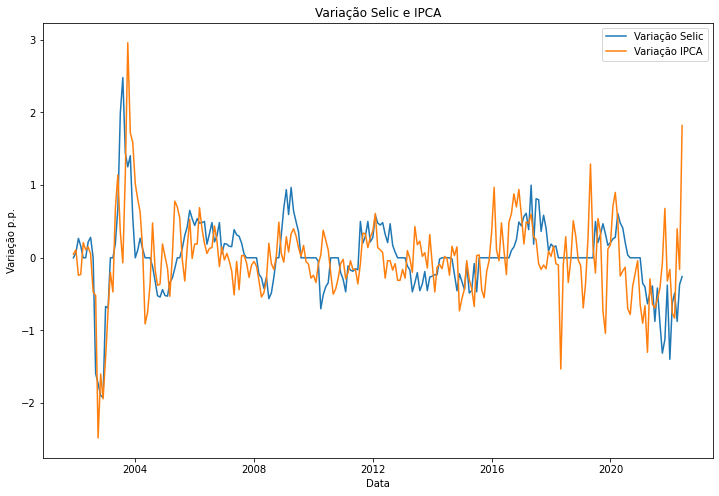

In [116]:
# variacao da taxa selic x variacao da taxa acumulada ipca
df4['perc_selic'] = (df4['selic'] - df4['selic'].shift(-1))
df4['perc_ipca'] = (df4['ipca_acumulado_12_meses'] - df4['ipca_acumulado_12_meses'].shift(-1))

fig, ax = plt.subplots(figsize = (12, 8))
sns.lineplot(data = df4, x = 'data', y = 'perc_selic', ax = ax, label = 'Variação Selic');
sns.lineplot(data = df4, x = 'data', y = 'perc_ipca', ax = ax, label = 'Variação IPCA');

plt.title('Variação Selic e IPCA');
plt.ylabel('Variação p.p.');
plt.xlabel('Data');

### 4.2. Sazonalidade

Verifica-se que o ano de maior variação da Selic após 2000 foi 2003. Fora isso, ao longo do ano a Selic tende a variar pouco. Verifica-se também baixa variação ao longo dos meses, não demonstrando uma sazonalidade clara.

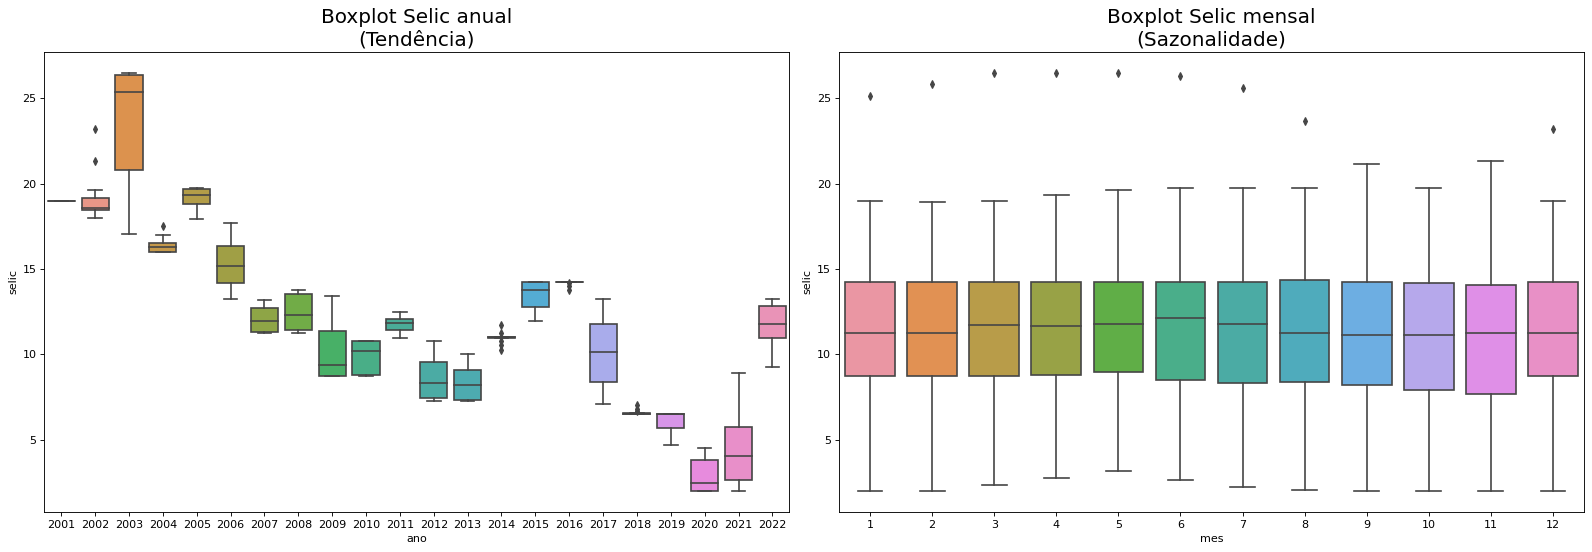

In [117]:
# Ano e Mês
years = df4['ano']
months = df4['mes']

# Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='ano', y='selic', data=df4, ax=axes[0]);
sns.boxplot(x='mes', y='selic', data=df4);

axes[0].set_title('Boxplot Selic anual\n(Tendência)', fontsize=18); 
axes[1].set_title('Boxplot Selic mensal\n(Sazonalidade)', fontsize=18);
plt.tight_layout();

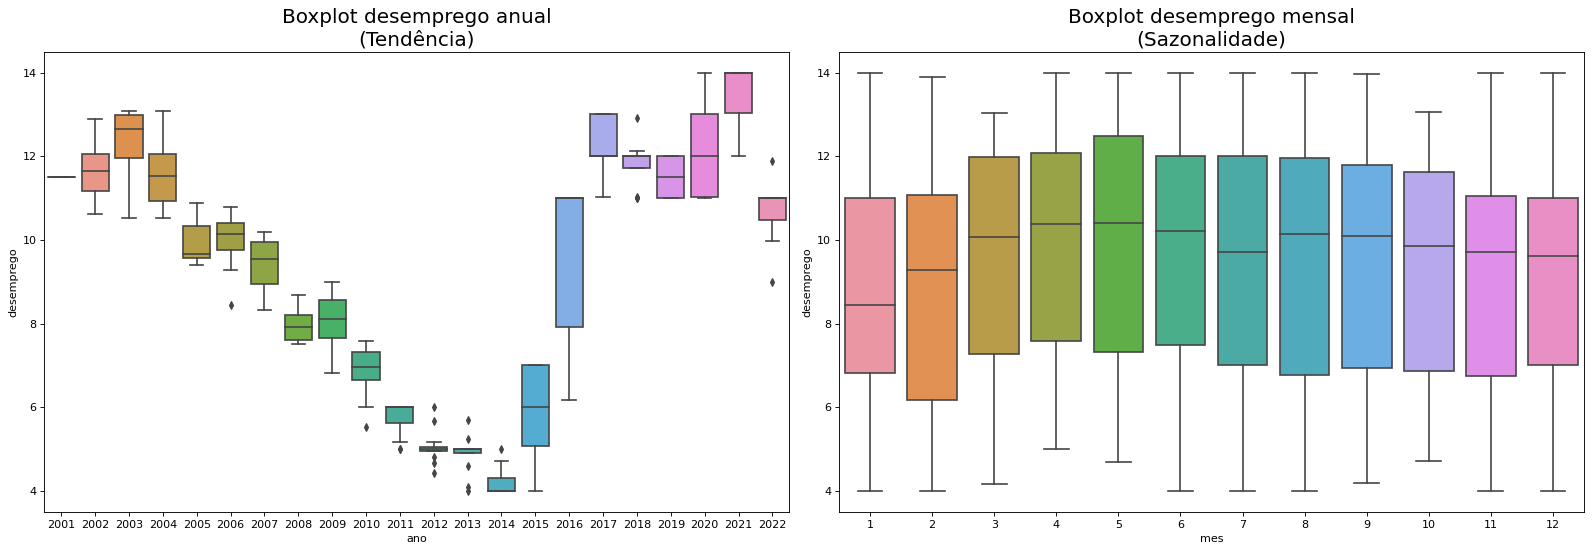

In [118]:
# Ano e Mês
years = df4['ano']
months = df4['mes']

# Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='ano', y='desemprego', data=df4, ax=axes[0]);
sns.boxplot(x='mes', y='desemprego', data=df4);

axes[0].set_title('Boxplot desemprego anual\n(Tendência)', fontsize=18); 
axes[1].set_title('Boxplot desemprego mensal\n(Sazonalidade)', fontsize=18);
plt.tight_layout();

### 4.3. Autocorrelação e Autocorrelação Parcial

A autocorrelação indica a correlação de Pearson da série com seus lags. Já a autocorrelação parcial é a correlação com os lags, mas removendo o efeito de lags intermediários.

#### 4.3.1. Série original

Verifica-se que há uma alta auto correlação entre os lags a partir do gráfico ACF, o que indica que os valores subsequentes da série são altamente dependentes dos seus valores anteriores, tornando a série mais próxima de um random walk do que uma série estacionária aleatória.

Além disso, pelo teste de Augmented Dickey-Fuller, o p-valor não se mostra tão significativo, o que indica que a série não pode ser considerada como estacionária.

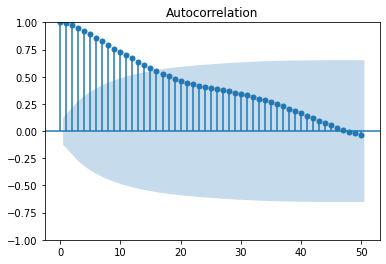

In [119]:
# autocorrelacao
plot_acf(df4['selic'], lags = 50);

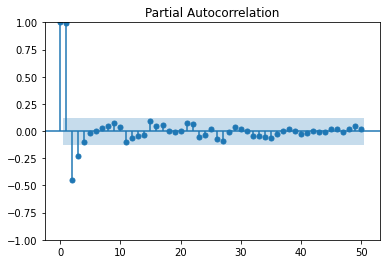

In [120]:
# autocorrelacao parcial
plot_pacf(df4['selic'], lags = 50, method='ywm');

In [219]:
stationary = adfuller(df4['selic'])
print(f"p-value stationarity: {stationary[1]}")

p-value stationarity: 0.07199719310626264


#### 4.3.2. Série diferenciada 1 vez

Após diferenciar a série 1 vez, verifica-se que a série se mostra mais estável em termos de tendência, existindo ainda algumas sazonalidades. Mas, observando o resultado do teste de Augmented Dickey-Fuller, verifica-se que é obtido um valor significativo para o p-valor, ou seja, pode-se considerar que a série é estacionária após diferenciá-la uma vez.

Além disso, verifica-se também que o valor de autocorrelação entre os lags da série decai muito mais rapidamente, ao contrário do gráfico ACF da série padrão.

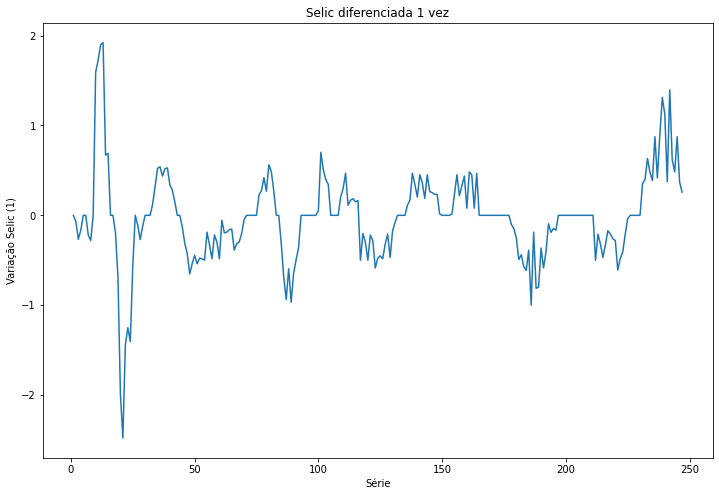

In [317]:
# Diferenciando série
one_time_diff = df4['selic'].diff(1).dropna()

# PLotando diferenciação
fig, ax = plt.subplots(figsize = (12, 8))
sns.lineplot(x = one_time_diff.index, y = one_time_diff.values, ax = ax);
ax.set_title('Selic diferenciada 1 vez')
ax.set_xlabel('Série');
ax.set_ylabel('Variação Selic (1)');

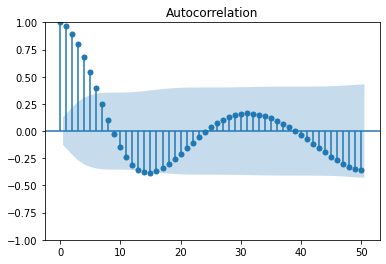

In [314]:
# autocorrelacao
plot_acf(one_time_diff, lags = 50);

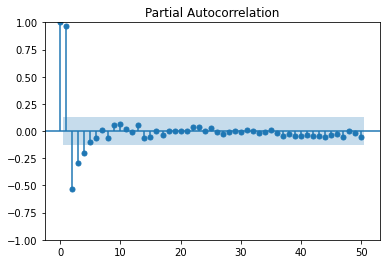

In [315]:
# autocorrelacao parcial
plot_pacf(one_time_diff, lags = 50, method='ywm');

In [316]:
stationary = adfuller(one_time_diff)
print(f"p-value stationarity: {stationary[1]}")

p-value stationarity: 0.017420056356389577


## 5.0. Preparação dos dados


In [121]:
df5 = df4.copy()

### 5.1. Separação treino-teste

In [122]:
threshold = '2022-03-01'

y = df5['selic']
X = df5[['desemprego', 'ipca_acumulado_12_meses']]

y_train = df5.query("data <= @threshold")['selic']
y_test = df5.query("data > @threshold")['selic']

X_train = df5.query("data <= @threshold")[['desemprego', 'ipca_acumulado_12_meses']]
X_test = df5.query("data > @threshold")[['desemprego', 'ipca_acumulado_12_meses']]

## 6.0. Machine Learning

In [123]:
df6 = df5.copy()

### 6.1. ARIMA

#### 6.1.1. Parâmetros p (AR), d (I), q (MA) - Auto Arima

A partir da automação do ARIMA, o qual avalia as melhores combinações de parâmetros a partir da métrica AIC, encontra-se os seguintes valores:

* p = 1 (PACF)
* d = 1 (Diferenciações)
* q = 3 (ACF)

O que está conforme a análise da série a partir dos gráficos ACF e PACF.

In [359]:
model = pm.auto_arima(y_train, start_p=1, start_q=3,
                        test='adf',       # use adftest to find optimal 'd'
                        max_p=4, max_q=4, # maximum p and q
                        d=None,           # let model determine 'd'
                        seasonal=False,   # No Seasonality
                        trace = True,
                        error_action='ignore',  
                        suppress_warnings=True)
model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=64.997, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=356.285, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=74.275, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=190.170, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=355.270, Time=0.04 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=100.101, Time=0.39 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=75.953, Time=0.32 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=66.853, Time=0.90 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=66.775, Time=1.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=149.860, Time=0.32 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=71.389, Time=0.49 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=65.647, Time=0.68 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=64.745, Time=0.92 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=1.12 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=67.226, Time=1.16

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  244
Model:               SARIMAX(1, 1, 3)   Log Likelihood                 -26.534
Date:                Wed, 07 Sep 2022   AIC                             63.069
Time:                        16:37:24   BIC                             80.534
Sample:                             0   HQIC                            70.104
                                - 244                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6612      0.049     13.548      0.000       0.566       0.757
ma.L1          0.1445      0.051      2.831      0.005       0.044       0.245
ma.L2          0.2230      0.049      4.535      0.000       0.127       0.319
ma.L3          0.3186      0.081      3.941      0.000       0.160       0.477
sigma2         0.0724      0.003     23.400      0.000       0.066       0.078
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1115.02
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.54   Skew:                             0.37
Prob(H) (two-sided):                  0.01   Kurtosis:                        13.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### 6.1.2. Validação Cruzada

Utilizando os parâmetros encontrados acima com o Auto-ARIMA, faz-se uma validação cruzada da série, prevendo 6 meses adiante para cada fold.

d:\Anaconda\envs\selic\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


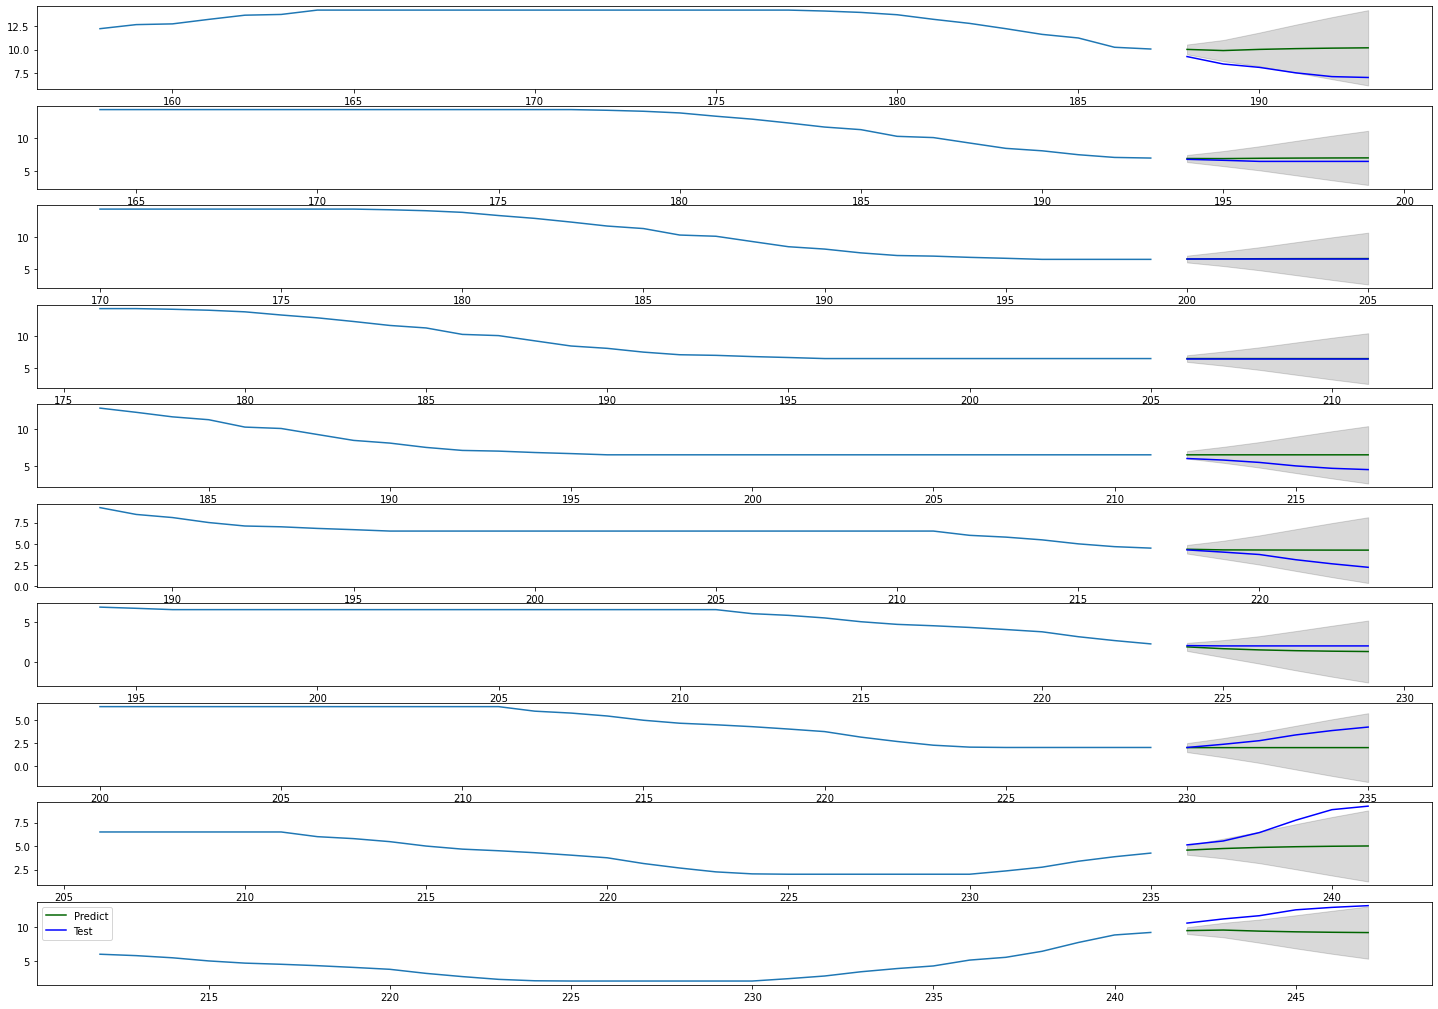

In [361]:
n_splits = 10
test_size = 6
tscv = TimeSeriesSplit(n_splits = n_splits, test_size = test_size)
model_list = []
test_periods = []
mae = []
mse = []
mape = []

fig, axes = plt.subplots(n_splits, 1, figsize = (25, 18))

for index, (train_index, test_index) in enumerate(tscv.split(y)):
    y_train_val, y_test_val = y[train_index], y[test_index]

    arima = ARIMA(y_train_val, order = (1, 1, 3))
    model = arima.fit()

    fc = model.get_forecast(test_size)
    yhat = fc.predicted_mean
    confint = fc.conf_int(alpha=0.05)
    lower_series = pd.Series(confint['lower selic'], index=test_index)
    upper_series = pd.Series(confint['upper selic'], index=test_index)

    # make series for plotting purpose
    fc_series = pd.Series(yhat, index=test_index)

    # Plot
    axes.ravel()[index].plot(y_train_val[-30:])
    axes.ravel()[index].plot(fc_series, color='darkgreen', label = 'Predict')
    axes.ravel()[index].plot(y_test_val, color='blue', label = 'Test')
    axes.ravel()[index].fill_between(lower_series.index, 
                                    lower_series, 
                                    upper_series, 
                                    color='k', alpha=.15)

    model_list.append(str(model).strip())
    test_periods.append(tuple(df6.iloc[test_index, [0, 1]].astype(str).agg('-'.join, axis = 1)))
    mae.append(mean_absolute_error(y_test_val, yhat))
    mse.append(mean_squared_error(y_test_val, yhat))
    mape.append(mean_absolute_percentage_error(y_test_val, yhat))

plt.legend();

In [364]:
metrics_arima = display_metrics(test_periods, "ARIMA(1, 1, 3)", mae, mse, mape)
metrics_arima

Mean MAE: 1.1467349448600825
Mean MSE: 2.6864987011388153
Mean MAPE: 0.2033563058641465


,Test Periods,Model,MAE,MSE,MAPE
0,"(2017-8, 2017-9, 2017-10, 2017-11, 2017-12, 20...","ARIMA(1, 1, 3)",2.168535,5.463206,0.288129
1,"(2018-2, 2018-3, 2018-4, 2018-5, 2018-6, 2018-7)","ARIMA(1, 1, 3)",0.395826,0.179949,0.060592
2,"(2018-8, 2018-9, 2018-10, 2018-11, 2018-12, 20...","ARIMA(1, 1, 3)",0.095758,0.009759,0.014732
3,"(2019-2, 2019-3, 2019-4, 2019-5, 2019-6, 2019-7)","ARIMA(1, 1, 3)",0.004327,0.000024,0.000666
4,"(2019-8, 2019-9, 2019-10, 2019-11, 2019-12, 20...","ARIMA(1, 1, 3)",1.260583,1.898849,0.254851
5,"(2020-2, 2020-3, 2020-4, 2020-5, 2020-6, 2020-7)","ARIMA(1, 1, 3)",0.936852,1.379072,0.347235
6,"(2020-8, 2020-9, 2020-10, 2020-11, 2020-12, 20...","ARIMA(1, 1, 3)",0.490380,0.275643,0.244944
7,"(2021-2, 2021-3, 2021-4, 2021-5, 2021-6, 2021-7)","ARIMA(1, 1, 3)",1.115379,1.889320,0.312629
8,"(2021-8, 2021-9, 2021-10, 2021-11, 2021-12, 20...","ARIMA(1, 1, 3)",2.317029,7.431497,0.293529
9,"(2022-2, 2022-3, 2022-4, 2022-5, 2022-6, 2022-7)","ARIMA(1, 1, 3)",2.682681,8.337667,0.216256
